In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub


In [ ]:
#Load Dataset
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
dataset_path = os.path.join(path, "Garbage classification", "Garbage classification")
classes = sorted(os.listdir(dataset_path))
num_classes = len(classes)

def load_images(dataset_path, classes, img_size=(128, 128)):
    images, labels = [], []
    for idx, cls in enumerate(classes):
        cls_path = os.path.join(dataset_path, cls)
        for fname in os.listdir(cls_path):
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                img = cv2.imread(os.path.join(cls_path, fname))
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(idx)
    X = np.array(images, dtype=np.float32)
    y = np.array(labels, dtype=np.int32)
    X = (X / 127.5) - 1.0  # Normalize to [-1, 1]
    return X, y

X, y = load_images(dataset_path, classes)
print("Loaded images:", X.shape)


✅ Loaded images: (2527, 128, 128, 3)


In [ ]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
#Add Gaussian Noise
def add_noise(images, noise_factor=0.2):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy, -1.0, 1.0)

X_train_noisy = add_noise(X_train)


In [ ]:
#Denoising Autoencoder
class TrashDenoise(Model):
    def __init__(self):
        super(TrashDenoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(128, 128, 3)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Conv2D(3, (3, 3), activation='tanh', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

autoencoder = TrashDenoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(X_train_noisy, X_train, epochs=30, batch_size=32, shuffle=True, validation_split=0.1)


Epoch 1/30
57/57 [==============================] - 4s 53ms/step - loss: 0.1201 - val_loss: 0.0743
Epoch 2/30
57/57 [==============================] - 3s 51ms/step - loss: 0.0677 - val_loss: 0.0613
Epoch 3/30
57/57 [==============================] - 3s 47ms/step - loss: 0.0410 - val_loss: 0.0294
Epoch 4/30
57/57 [==============================] - 3s 46ms/step - loss: 0.0291 - val_loss: 0.0269
Epoch 5/30
57/57 [==============================] - 3s 46ms/step - loss: 0.0274 - val_loss: 0.0259
Epoch 6/30
57/57 [==============================] - 3s 46ms/step - loss: 0.0262 - val_loss: 0.0239
Epoch 7/30
57/57 [==============================] - 3s 47ms/step - loss: 0.0216 - val_loss: 0.0186
Epoch 8/30
57/57 [==============================] - 3s 48ms/step - loss: 0.0179 - val_loss: 0.0167
Epoch 9/30
57/57 [==============================] - 3s 48ms/step - loss: 0.0167 - val_loss: 0.0160
Epoch 10/30
57/57 [==============================] - 3s 49ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 11/

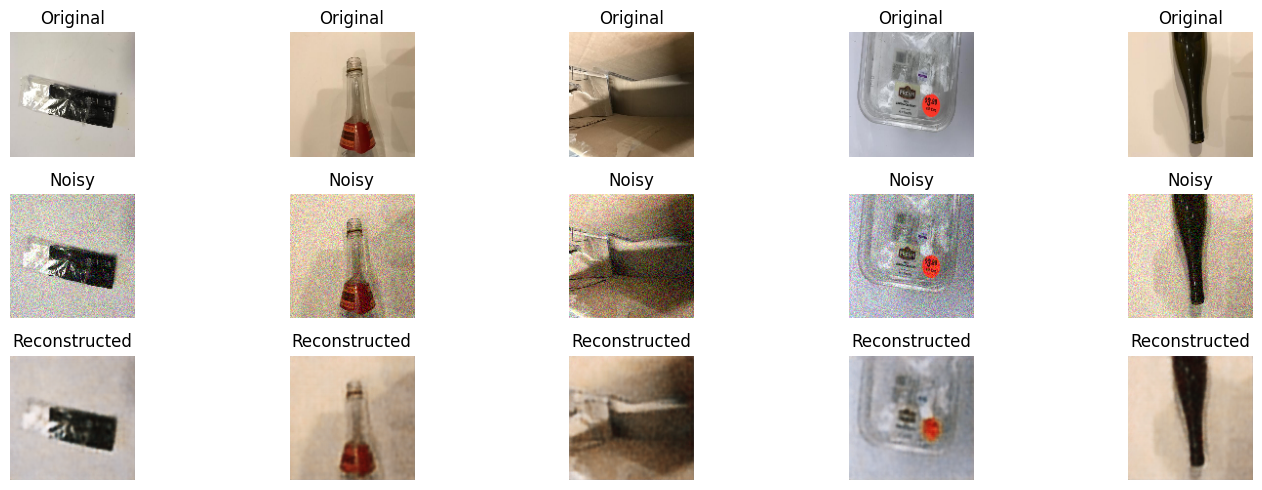

In [ ]:
#Denoise Train/Test Sets
X_train_denoised = autoencoder.predict(add_noise(X_train))
X_test_denoised = autoencoder.predict(add_noise(X_test))

from tensorflow.keras.applications.resnet50 import preprocess_input
X_train_denoised = preprocess_input(X_train_denoised * 127.5 + 127.5)
X_test_denoised = preprocess_input(X_test_denoised * 127.5 + 127.5)

#Visualize Original vs Noisy vs Reconstructed
num_samples = 5
indices = np.random.choice(len(X_train), num_samples, replace=False)
originals = X_train[indices]
noisy_inputs = add_noise(originals)
reconstructed = autoencoder.predict(noisy_inputs)

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(3, num_samples, i + 1)
    plt.imshow((originals[i] + 1) / 2)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(3, num_samples, i + 1 + num_samples)
    plt.imshow((noisy_inputs[i] + 1) / 2)
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
    plt.imshow((reconstructed[i] + 1) / 2)
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()

